In [ ]:
!pip install -q opencv-python tensorflow
import os, cv2, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import json

In [ ]:
drive.mount('/content/drive', force_remount=True)
DATA_FOLDER = '/content/drive/MyDrive/LandMark Images Pre-Processed'

Mounted at /content/drive


In [ ]:
# Locations of landmarks from my image dataset
LOCATION_MAP = {
    "Adam's Peak": "Rathnapura, Sabaragamuwa Province, Sri Lanka",
    "Ancient City of Polonnaruwa": "Polonnaruwa, North Central Province, Sri Lanka",
    "Beruwala Light House": "Beruwala, Western Province, Sri Lanka",
    "British War Cemetery": "Kandy, Central Province, Sri Lanka",
    "Bundala National Park": "Hambantota, Southern Province, Sri Lanka",
    "Delft Island": "Jaffna, Northern Province, Sri Lanka",
    "Dowa Rock Temple": "Bandarawela, Uva Province, Sri Lanka",
    "Ganagaramaya Temple": "Colombo, Western Province, Sri Lanka",
    "Henarathgoda Botanical Gard": "Gampaha, Western Province, Sri Lanka",
    "Hortains Plain": "Nuwara Eliya, Central Province, Sri Lanka",
    "Independance Square": "Colombo, Western Province, Sri Lanka",
    "Jaya Sri Maha Bodhi": "Anuradhapura, North Central Province, Sri Lanka",
    "Lotus Tower": "Colombo, Western Province, Sri Lanka",
    "Maligawa Buddha Statue": "Kandy, Central Province, Sri Lanka",
    "Nine Arches Bridge": "Ella, Uva Province, Sri Lanka",
    "Pinnawala Elephant Orphanage": "Kegalle, Sabaragamuwa Province, Sri Lanka",
    "Sigiriya": "Matale, Central Province, Sri Lanka",
    "Sinharaja Forest": "Ratnapura, Sabaragamuwa Province, Sri Lanka",
    "Sri Dalada Maligawa": "Kandy, Central Province, Sri Lanka",
    "Star Fort": "Matara, Southern Province, Sri Lanka",
    "Turtle Hatchery": "Kosgoda, Southern Province, Sri Lanka",
    "Vavuniya Archaeological Museum": "Vavuniya, Northern Province, Sri Lanka",
    "Wilapattu National Park": "Puttalam, North Western Province, Sri Lanka",
    "Yapahuwa Rock Fortress": "Yapahuwa, North Western Province, Sri Lanka",
}

In [ ]:
# Load images from flat structure: landmark/train/images.jpg
def load_images():

    splits = ['train', 'test', 'valid']
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # Get landmark names (folders containing train/test/valid)
    classes = []
    for item in os.listdir(DATA_FOLDER):
        item_path = os.path.join(DATA_FOLDER, item)
        if os.path.isdir(item_path):
            subfolders = os.listdir(item_path)
            if all(split in subfolders for split in splits):
                classes.append(item)

    classes = sorted(classes)
    print(f"📁 Found {len(classes)} landmarks: {classes}")

    # Create class to index mapping
    class_to_idx = {name: i for i, name in enumerate(classes)}

    # Load images from each split
    for landmark in classes:
        for split in splits:
            # Direct path: landmark/train/ (no inner folder)
            source_path = os.path.join(DATA_FOLDER, landmark, split)

            if not os.path.exists(source_path):
                print(f"⚠️ Missing: {landmark}/{split}")
                continue

            # Get images directly from split folder
            images = [f for f in os.listdir(source_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]

            print(f"📂 {landmark}/{split}: {len(images)} images")

            for img_name in images:
                try:
                    img_path = os.path.join(source_path, img_name)
                    img = np.array(Image.open(img_path).convert('RGB'))
                    img_resized = cv2.resize(img, (290, 290)) / 255.0

                    # Add to appropriate list
                    if split == 'train':
                        X_train.append(img_resized)
                        y_train.append(class_to_idx[landmark])
                    elif split == 'valid':
                        X_val.append(img_resized)
                        y_val.append(class_to_idx[landmark])
                    elif split == 'test':
                        X_test.append(img_resized)
                        y_test.append(class_to_idx[landmark])

                except Exception as e:
                    print(f"⚠️ Failed {img_name}: {e}")

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(f"\n✅ Loaded:")
    print(f"   Train: {len(X_train)} images")
    print(f"   Val:   {len(X_val)} images")
    print(f"   Test:  {len(X_test)} images")

    return X_train, X_val, X_test, y_train, y_val, y_test, classes

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, CLASS_NAMES = load_images()

📁 Found 24 landmarks: ['Adams Peak', 'Ancient City of Polonnaruwa', 'Beruwala Light House', 'British War Cemetery', 'Bundala National Park', 'Delft Island', 'Dowa Rock Temple', 'Ganagaramaya Temple', 'Henarathgoda Botanical Garden', 'Hortains Plain', 'Independance Square', 'Jaya Sri Maha Bodhi', 'Lotus Tower', 'Maligawa Buddha Statue', 'Nine Arches Bridge', 'Pinnawala Elephant Orphanage', 'Sigiriya', 'Sinharaja Forest', 'Sri Dalada Maligawa', 'Star Fort', 'Turtle Hatchery', 'Vavuniya Archaeological Museum', 'Wilapattu National Park', 'Yapahuwa Rock Fortress']
📂 Adams Peak/train: 18 images
📂 Adams Peak/test: 1 images
📂 Adams Peak/valid: 2 images
📂 Ancient City of Polonnaruwa/train: 18 images
📂 Ancient City of Polonnaruwa/test: 1 images
📂 Ancient City of Polonnaruwa/valid: 1 images
📂 Beruwala Light House/train: 18 images
📂 Beruwala Light House/test: 1 images
📂 Beruwala Light House/valid: 2 images
📂 British War Cemetery/train: 18 images
📂 British War Cemetery/test: 1 images
📂 British War 

In [ ]:
# Building CNN Model
base = tf.keras.applications.EfficientNetB0(
    input_shape=(290, 290, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

inputs = layers.Input(shape=(290, 290, 3))

# EfficientNet expects 0-255, your images are 0-1
# Scale back to 0-255 then let EfficientNet handle normalization

x = layers.Lambda(lambda x: x * 255.0)(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.BatchNormalization()(x)
x = layers.Dropout(0.55)(x)

x = layers.Dense(98, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model = Model(inputs, outputs)

# Higher learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 290, 290, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 290, 290, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 10, 10, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 98)             │       125,538 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 24)             │         2,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,182,605 (15.96 MB)

 Trainable params: 130,474 (509.66 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_accuracy',  # Monitor accuracy not the val loss
        mode='max'
    )],
    verbose=1
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.0458 - loss: 5.8219 - val_accuracy: 0.1702 - val_loss: 3.2864
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.1490 - loss: 4.2213 - val_accuracy: 0.3191 - val_loss: 2.9752
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.2272 - loss: 3.3858 - val_accuracy: 0.5745 - val_loss: 2.7120
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.3137 - loss: 2.8604 - val_accuracy: 0.5319 - val_loss: 2.4906
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - accuracy: 0.4273 - loss: 2.3067 - val_accuracy: 0.6383 - val_loss: 2.3061
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.5087 - loss: 2.0382 - val_accuracy: 0.6809 - val_loss: 2.1530
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.5470 - loss: 1.9597 - val_accuracy: 0.7021 - val_loss: 2.0054
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.5569 - loss: 1.7591 - val_accuracy: 0.7234 - val_loss:

Visualization: Checking for overfitting

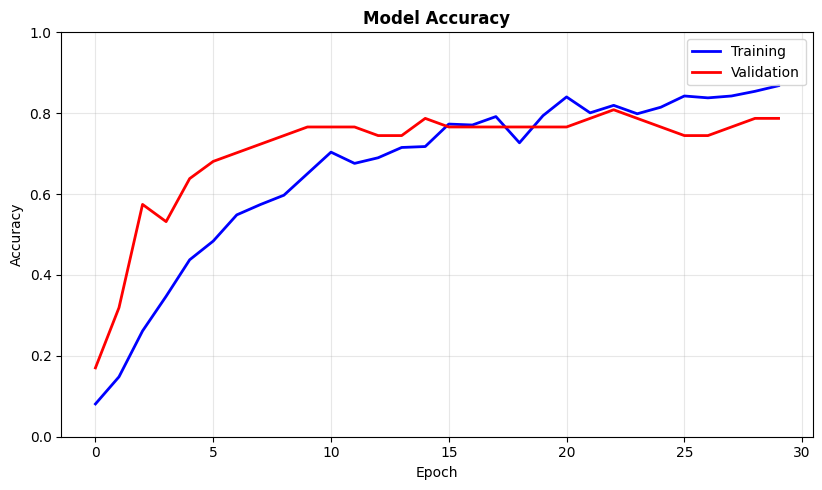

In [ ]:
plt.figure(figsize=(16, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
plt.title('Model Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
print("The model is slightly overfitting due to the preaugmented dataset")

The model is slightly overfitting due to the pre augmented dataset


In [ ]:
# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.2%}")
print(f"Final Validation Accuracy: {final_val_acc:.2%}")
print(f"Gap: {final_train_acc - final_val_acc:.2%} ")


Final Training Accuracy: 86.81%
Final Validation Accuracy: 78.72%
Gap: 8.08% 


In [ ]:
# This function returns the landmark name and its location
def predict(img_path):
    img = Image.open(img_path).convert('RGB')
    img_array = cv2.resize(np.array(img), (290, 290)) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_idx = np.argmax(model.predict(img_array, verbose=0)[0])
    landmark = CLASS_NAMES[pred_idx]
    location = LOCATION_MAP.get(landmark, "Unknown")

    return {'name': landmark, 'place': location}

In [ ]:
# Testing the model
result = predict('/content/drive/MyDrive/LandMark Images Pre-Processed/Ancient City of Polonnaruwa/train/pic-3_png.rf.1a402efbd3d3296ed9f1c959c690c31c.jpg')
print(f"Landmark: {result['name']}")
print(f"Location: {result['place']}")


Landmark: Ancient City of Polonnaruwa
Location: Polonnaruwa, North Central Province, Sri Lanka


In [ ]:
model.save('/content/drive/MyDrive/EfficientNetB0_CNN_Model.keras')
print("✅ Model saved")

✅ Model saved


In [ ]:
# Save class names
with open('/content/drive/MyDrive/class_names.json', 'w') as f:
    json.dump(CLASS_NAMES, f)
print("✅ Class names saved")

✅ Class names saved
